In [2]:
import numpy as np
import os, sys
import yaml
import astropy.io.ascii as ascii
%pylab inline
from astropy.io import fits
from astropy.table import Table,join
import astropy as ap
from multiprocessing import Pool,Value
from functools import partial
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy import ndimage
from matplotlib.patches import Ellipse, Circle
from sklearn import linear_model


Populating the interactive namespace from numpy and matplotlib


In [12]:
source_id = np.loadtxt('source_id.txt',dtype=str)
z_table = []
z_2d = []
z_2d_up1 = []
z_2d_low1 = []
for id_name in source_id:
    z = Table.read('output_10pix_vor_nosm/ELD_oh12_2d_id%s.txt'%id_name,format='ascii.commented_header')
    z_table.append(z)
    z_2d.append(z['me'].copy())
    z_2d_up1.append(z['me_up1sig'].copy())
    z_2d_low1.append(z['me_low1sig'].copy())

In [14]:
fitnumber = ['0'*(2-len(str(i)))+str(i) for i in np.arange(len(z_2d))+1]

galfit = []
for i,n in enumerate(source_id):
    file = open("galfit/galfit_output_10pix/galfit_%s.txt"%n, "r")
    name = file.readlines()
    x = float(name[40][4:11])
    y = float(name[40][13:20])
    R_e = float(name[42][4:11])
    ab = float(name[47][4:11])
    angle = float(name[48][4:11])
    
    a = R_e/ab**0.5
    b = R_e*ab**0.5
    
    galfit.append(np.array([x,y,a,b,angle]))

In [3]:
from os import path
import numpy as np
import matplotlib.pyplot as plt

import vorbin
from vorbin.voronoi_2d_binning import voronoi_2d_binning

In [4]:
def voronoi_binned_data(x,y,signal,noise,binNum):
    signal_bin = []
    noise_bin = []
    x_center = []
    y_center = []
    for i in np.unique(binNum):
        idx = binNum==i
        signal_bin.append(np.sum(signal[idx]))
        noise_bin.append(np.sqrt(np.sum(noise[idx]**2)))
        x_center.append(x[idx].mean())
        y_center.append(y[idx].mean())
    return np.array(x_center),np.array(y_center),np.array(signal_bin),np.array(noise_bin)


def _display_pixels(x, y, counts, pixelsize):
    """
    Display pixels at coordinates (x, y) coloured with "counts".
    This routine is fast but not fully general as it assumes the spaxels
    are on a regular grid. This needs not be the case for Voronoi binning.

    """
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    nx = int(round((xmax - xmin)/pixelsize) + 1)
    ny = int(round((ymax - ymin)/pixelsize) + 1)
    img = np.full((nx, ny), np.nan)  # use nan for missing data
    j = np.round((x - xmin)/pixelsize).astype(int)
    k = np.round((y - ymin)/pixelsize).astype(int)
    img[j, k] = counts

    plt.imshow(np.rot90(img), interpolation='nearest', cmap='prism',
               extent=[xmin - pixelsize/2, xmax + pixelsize/2,
                       ymin - pixelsize/2, ymax + pixelsize/2])


In [29]:
def display_voronoi(x, y, counts, pixelsize, z_2d,ax=False):

    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    nx = int(np.round((xmax - xmin)/pixelsize) + 1)
    ny = int(np.round((ymax - ymin)/pixelsize) + 1)
    img = np.full((nx, ny), np.nan)  # use nan for missing data
    j = np.round((x - xmin)/pixelsize).astype(int)
    k = np.round((y - ymin)/pixelsize).astype(int)
#     _,_,bin_signal,noise_signal = voronoi_binned_data(x,y,flux,err,binNum)
#     img[j, k] = array([(bin_signal/noise_signal)[binNum[i]==np.unique(binNum)][0] for i in range(len(binNum))])
    img[j, k] = array([(z_2d)[binNum[i]==np.unique(binNum)][0] for i in range(len(binNum))])

    if ax != False:
        im = ax.imshow(np.rot90(img), interpolation='nearest', cmap='jet',
               extent=[xmin - pixelsize/2, xmax + pixelsize/2,
                       ymin - pixelsize/2, ymax + pixelsize/2])
        colorbar(im,ax=ax)
    else:
        plt.imshow(np.rot90(img), interpolation='nearest', cmap='jet',
                   extent=[xmin - pixelsize/2, xmax + pixelsize/2,
                           ymin - pixelsize/2, ymax + pixelsize/2])
        plt.colorbar()

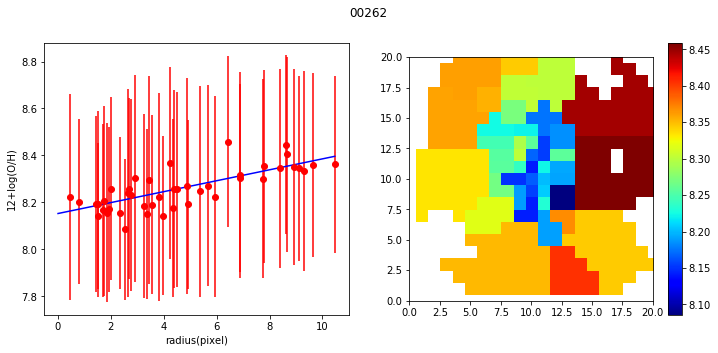

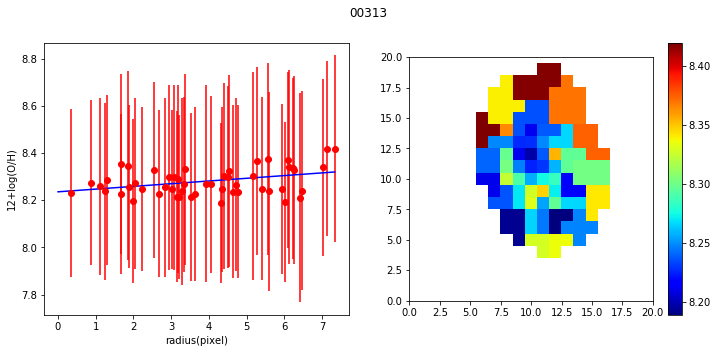

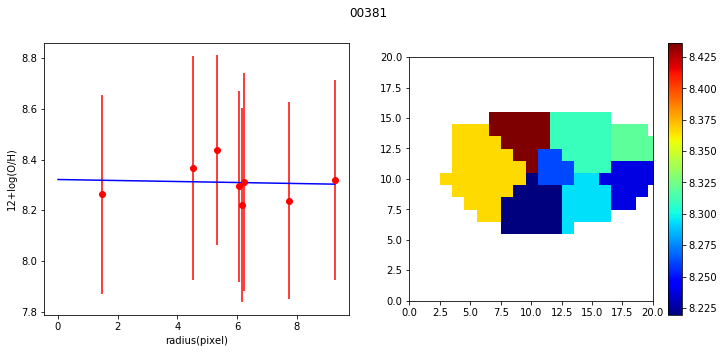

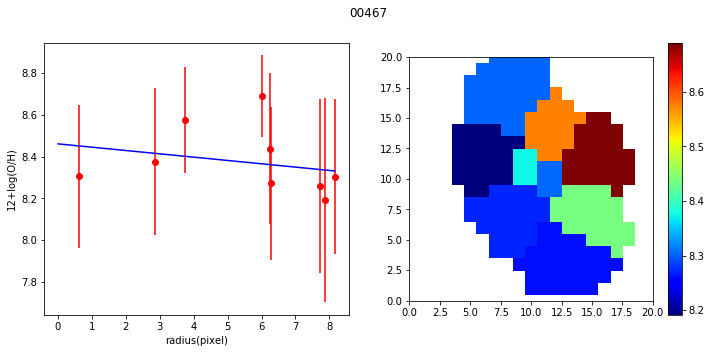

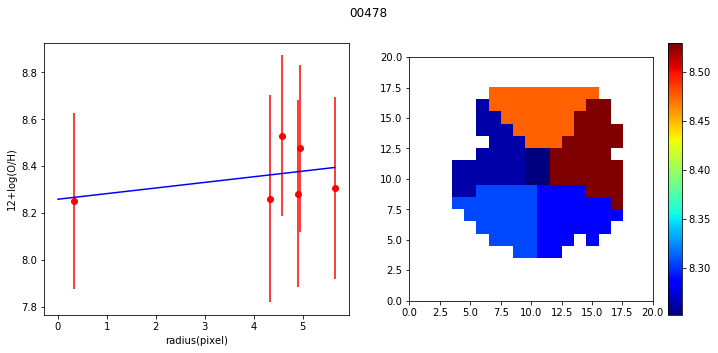

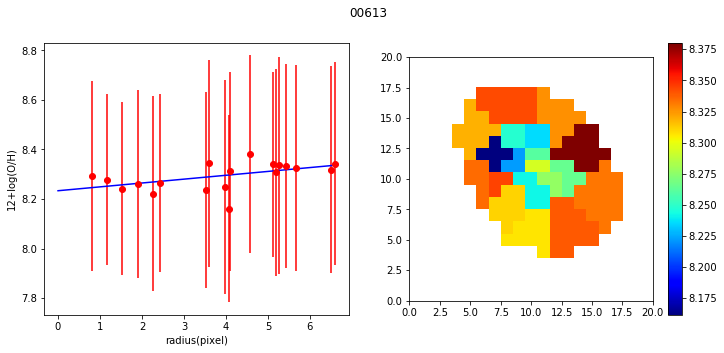

/home/zihao/miniconda3/envs/Tf_1/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


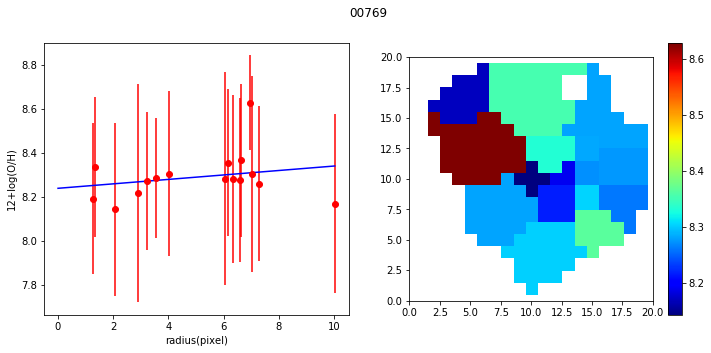

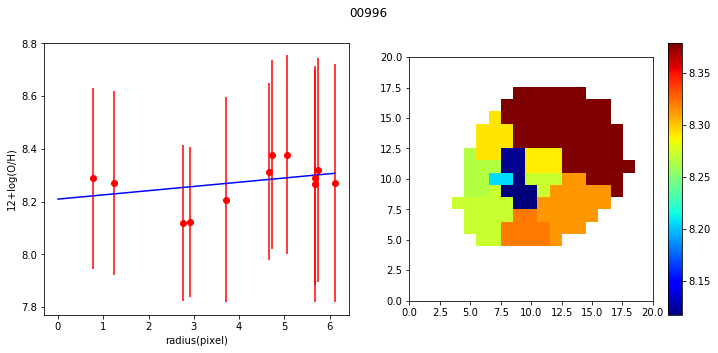

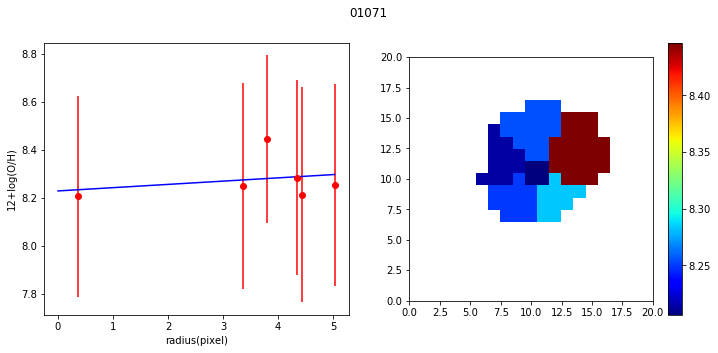

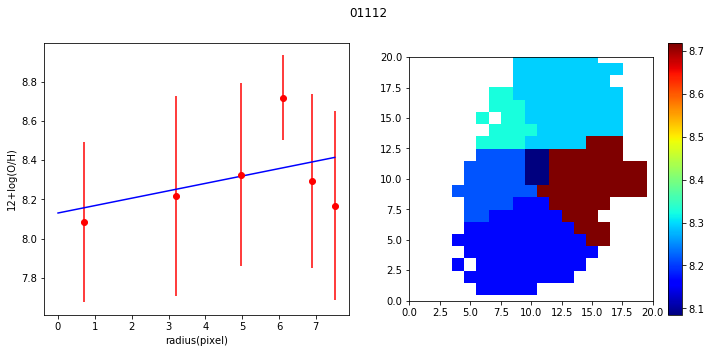

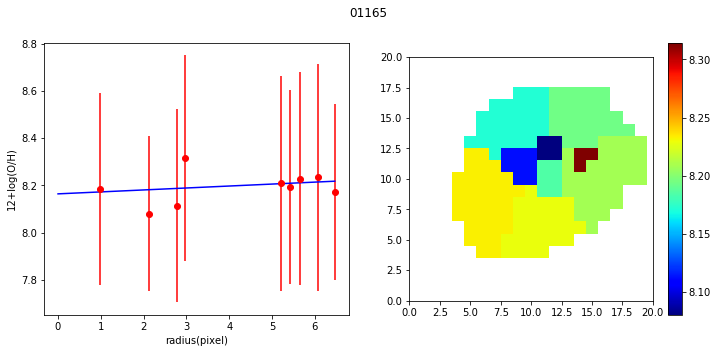

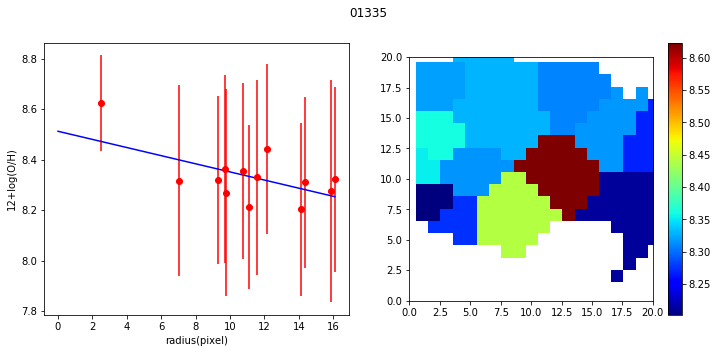

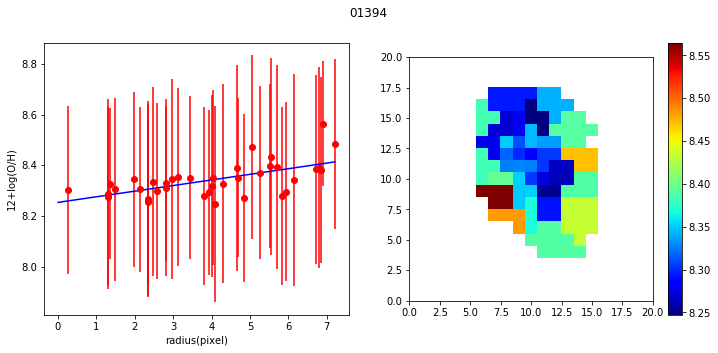

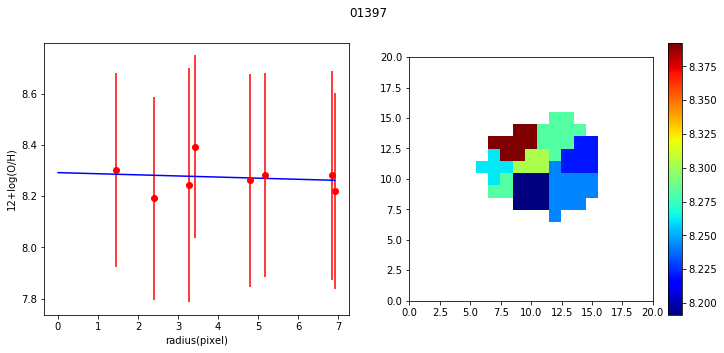

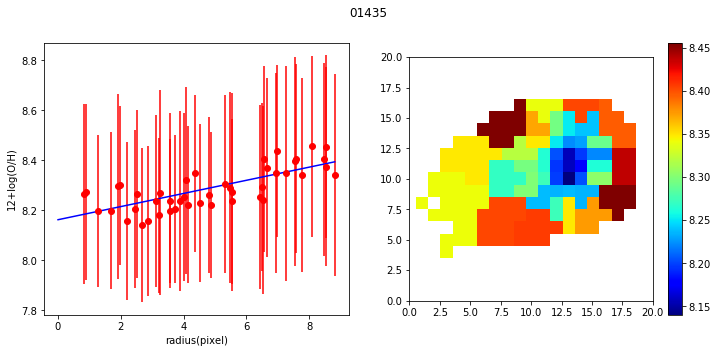

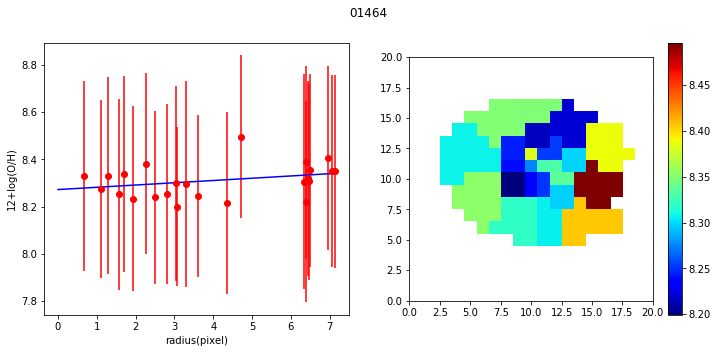

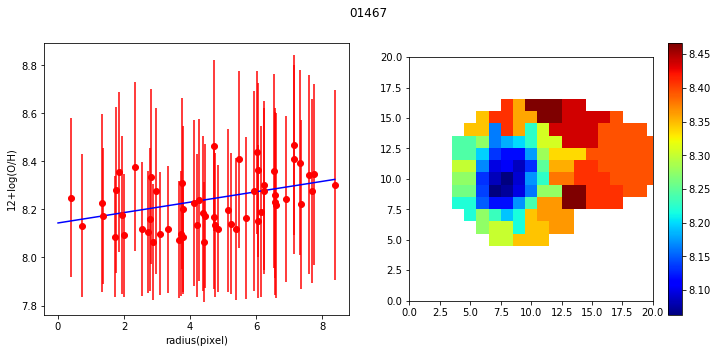

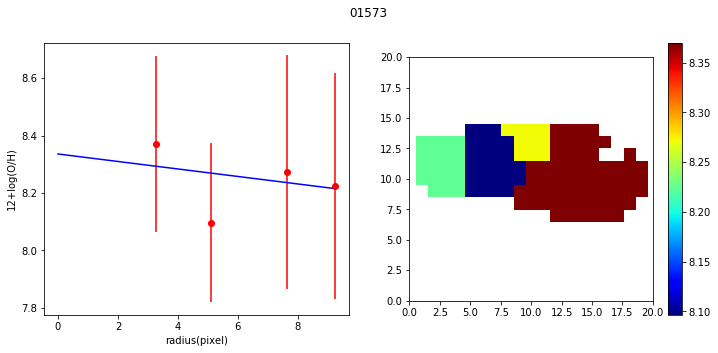

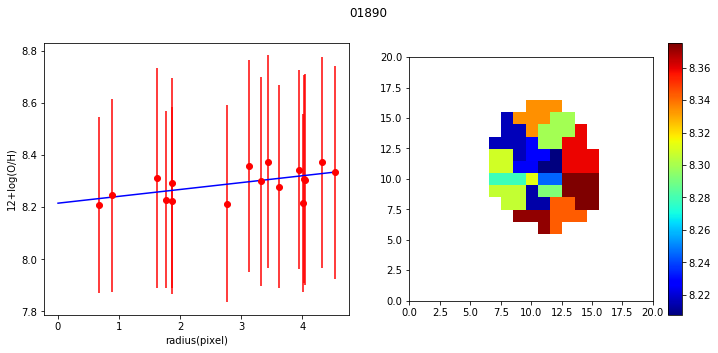

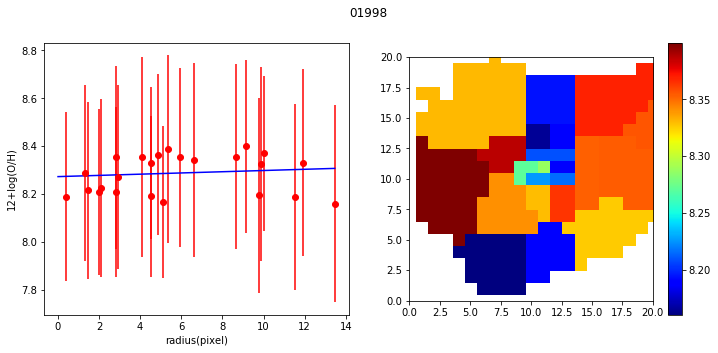

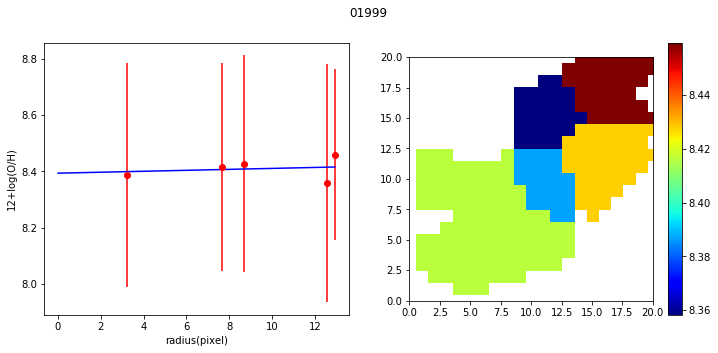

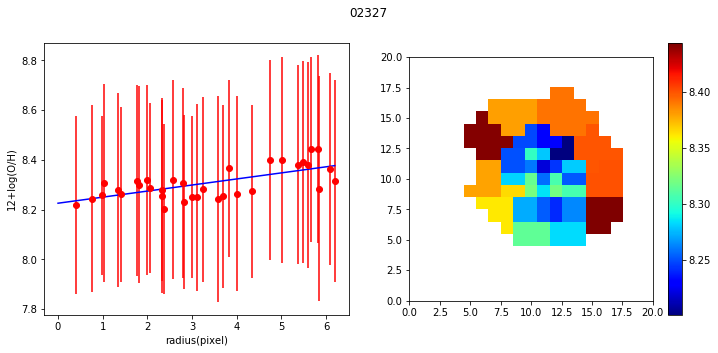

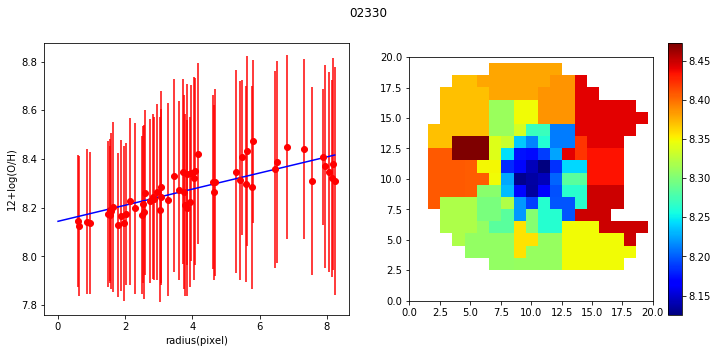

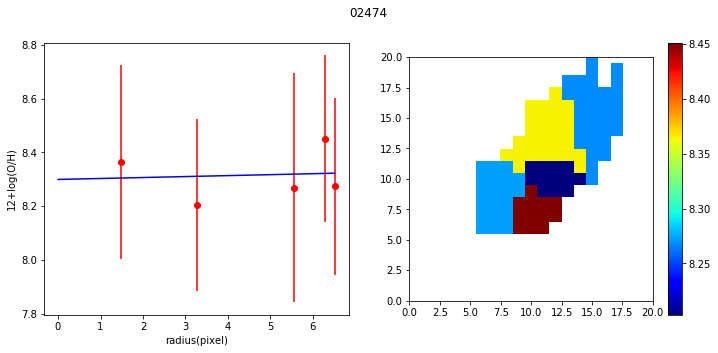

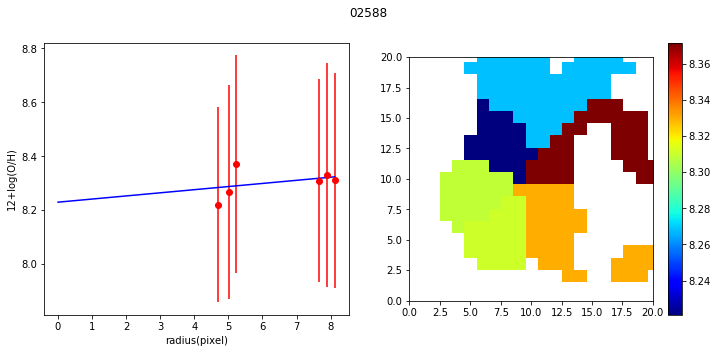

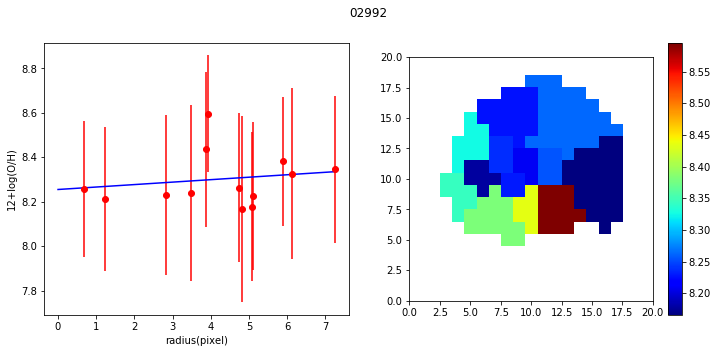

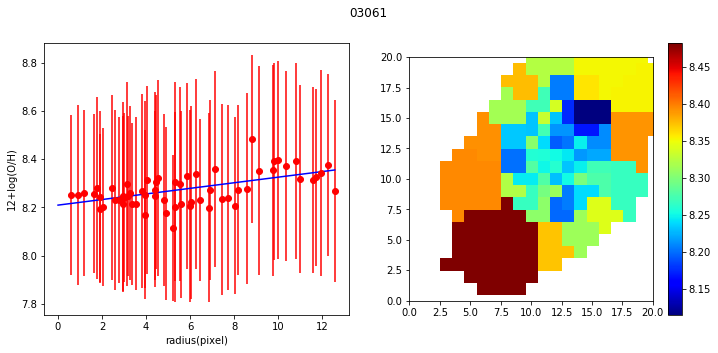

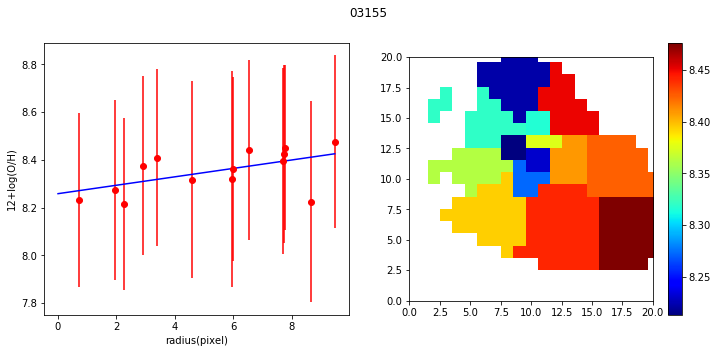

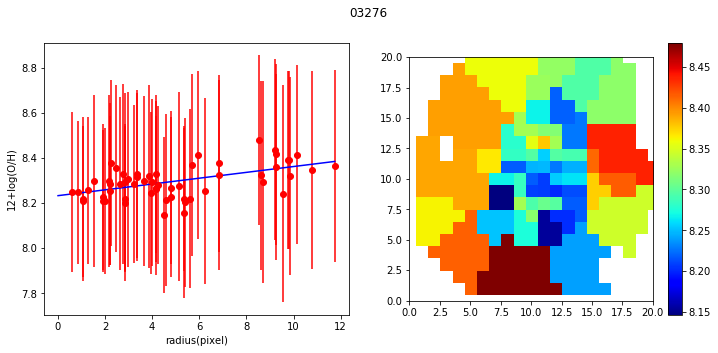

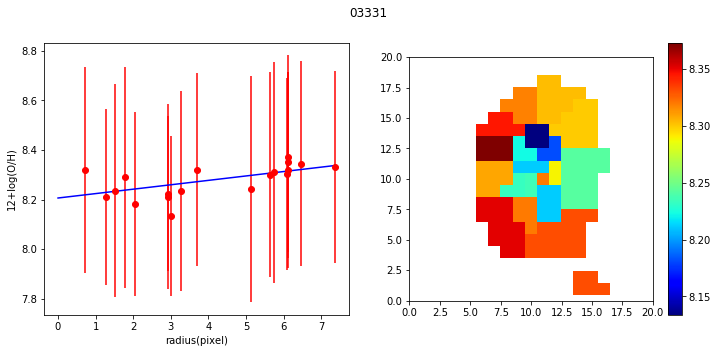

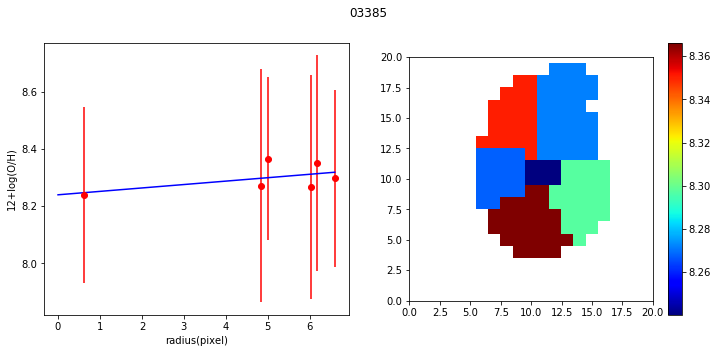

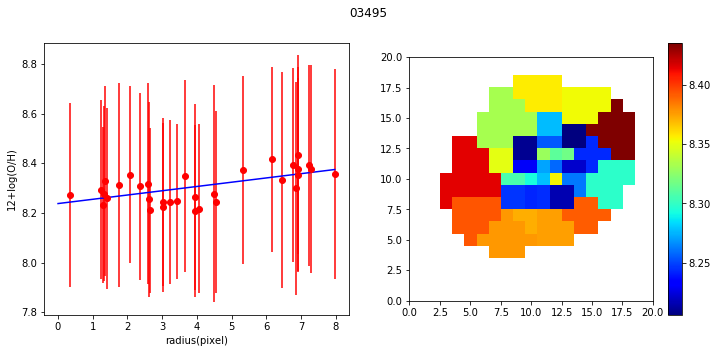

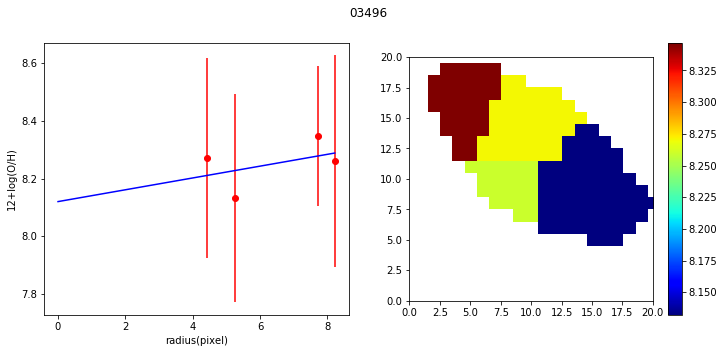

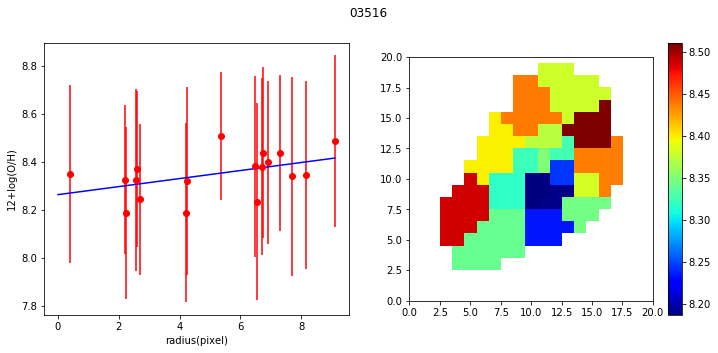

In [31]:
for i,id_name in enumerate(source_id):
# for i,id_name in enumerate([source_id[1]]):
#     print('-----------------------------------------------')
#     print('Fitting source %s'%id_name)
#     print('-----------------------------------------------')

    val = Value('d', 1)
    info = Table.read('../grismspec_boss1244_210627/boss1244_DR210308_%s.row.fits'%id_name,hdu=1)
    ra = info['ra']
    dec = info['dec']
    z = info['redshift']
    g141 = info['t_g141']
    hdu = fits.open('../grismspec_boss1244_210627/boss1244_DR210308_%s.full.fits'%id_name)
    sp_1d = Table.read('../grismspec_boss1244_210627/boss1244_DR210308_%s.1D.fits'%id_name,hdu=1)
    wave_1d = sp_1d['wave']
    flat = sp_1d['flat']
    Elines = {}
    w = 10
    seg_hdu = fits.open('seg_stamp_10pix/seg_%s.fits'%id_name)
    seg = seg_hdu[0].data.astype(float)
    seg[seg!=seg[w,w]]=np.nan
    seg /= seg[w,w]
    for j in range(len(hdu)):
        try:
            header = hdu[j].header
            EXTVER = header['EXTVER']
            EXTNAME = header['EXTNAME']
            if EXTVER in ['OIII','OII','Hb','Hg'] and EXTNAME =='LINE':

                flat_idx = np.argmin(np.abs(wave_1d - hdu[j].header['WAVELEN']))
                EL_img = hdu[j].data[66-w:66+w,66-w:66+w]
                EL_img_sm = ndimage.gaussian_filter(EL_img,3.333/2.355)

                Elines['flux_'+EXTVER] = (seg*EL_img_sm).flatten()
#             elif EXTVER in ['OII','Hb','OIII'] and EXTNAME =='LINEWHT':
            elif EXTVER in ['OIII','OII','Hb','Hg'] and EXTNAME =='LINEWHT':
                err_img = 1/(hdu[j].data[66-w:66+w,66-w:66+w])**0.5
                # err_img_sm = ndimage.gaussian_filter(err_img,3.333/2.355)
                Elines['err_'+EXTVER] = (seg*err_img).flatten()
        except:
            continue
            
    tresh = 0
    crop_idx = where((Elines['flux_OIII']/Elines['err_OIII']<=tresh)|np.isnan(Elines['err_OIII']))
    Elines['flux_OIII'] = np.delete(Elines['flux_OIII'],crop_idx)
    Elines['err_OIII'] = np.delete(Elines['err_OIII'],crop_idx)
    x,y = np.meshgrid(linspace(1,20,20),linspace(1,20,20))
    x = np.delete(x.flatten(),crop_idx)
    y = np.delete(y.flatten(),crop_idx)
    
    for line in ['OII','Hb','Hg']:
        Elines['flux_'+line] = np.delete(Elines['flux_'+line],crop_idx)
        Elines['err_'+line] = np.delete(Elines['err_'+line],crop_idx)
    
    binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(x, y, Elines['flux_OIII'], Elines['err_OIII'], 2.5, plot=False, quiet=True)
    
    x,y = xNode,yNode

    x -= galfit[i][0]
    y -= galfit[i][1]
    coord = np.array([x.flatten(),y.flatten()])

    angle = -(90+galfit[i][4])*2*np.pi/360

    ab = galfit[i][3]/galfit[i][2]
    trans1 = np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]])
    trans2 = np.array([[1,0],[0,1/ab]])
    mat_trans = trans2@trans1
    
    x,y=mat_trans@coord
    d = (x**2+y**2)**0.5
    
    
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    ax[0].errorbar(d,z_2d[i],yerr=(z_2d_up1[i]-z_2d[i],z_2d_up1[i]-z_2d[i]),fmt='o',ecolor='r',color='r',elinewidth=0,capsize=0)
#     # Fit linear regressing to metallicity versus radius
    x = d
    y = z_2d[i].flatten()
    weight = (z_2d_up1[i]-z_2d_low1[i])/2
    model = linear_model.LinearRegression()
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    model.fit(x[~isnan(weight)],y[~isnan(weight)],weight[~isnan(weight)])
    ax[0].plot(array([0,d.max()]),array([model.intercept_[0],model.intercept_[0]+model.coef_[0][0]*d.max()]),c='blue')
    
    ax[0].set_xlabel('radius(pixel)')
    ax[0].set_ylabel('12+log(O/H)')
    plt.suptitle(source_id[i])
    
    x,y = np.meshgrid(linspace(1,20,20),linspace(1,20,20))
    x = np.delete(x.flatten(),crop_idx)
    y = np.delete(y.flatten(),crop_idx)
    display_voronoi(x,y,binNum,1,z_2d[i],ax[1])
    ax[1].set_xlim(0,20)
    ax[1].set_ylim(0,20)
    show()